# Lab Course: Distributed Data Analytics Exercise Sheet 2
<b>Submitted By: Mohit Bansal</b><br>
<b>Student ID: 279314</b><br>

## Exercise 1: Point to Point Communication (10 Points)

+ In this exercise you will write a parallel program using point-to-point communication routines. 
+ Suppose a worker with rank 0 has an integer array and it wants to send to all P − 1 workers in COMM WORLD, lets call this routine sendAll.

### Short description of a naive way: NsendAll

+ A naive way to send this array is using a for loop at worker 0 and sequentially send it to all other processes i.e. it will take P − 1 steps. 

Hint: Make sure all the workers exit the sendAll routine at the same time i.e its useful to use MPI Barrier at the end of this function.

### Short description of an efficient way: EsendAll

+ Another possible ways is to use a recursive doubling algorithm, which will require log(P) steps. 
+ Suppose you have P workers, where P ≥ 2d i.e. if P = 33 than d = 5 and rank is the current worker ID. Lets say the root worker has rank 0. The root worker sends to worker with Rank 1 and worker with Rank 2 only. 
+ All other workers first receive a message from recvProc, i.e.

    $recvP roc = int((rank − 1)/2)$


+ and sends to two more processes
    
    $destA = 2 × rank + 1 and destB = 2 × rank + 2$
    
    
+ But before sending, make sure destA and destB exist. 
+ To make sure every process has finished put a MPI.Barrier() just before returning from sendAll routine.

Your tasks are to write:
1. Implement the NsendAll routine using the naive way i.e using a single for loop.
2. Implement the EsendAll routine using the efficient way as explained above.
3. Compare performance of the two implementations by recording the time to finish each task. You can fix the number of process P = 2d i.e. 16 and 32, and send an array of size $10^3$ or $10^5$ or $10^7$. 

[Hint: see which of the array sizes fit in your memory and even if you have less cores you should still use 16 and 32].

## Solution

Naive Send all is easy to implement and has been used in the previous exercises as well. 

In NSendAll, a root node will send the data to all the workers sequentially and the workers will recieve it.

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 23 09:21:24 2018

@author: mundanemohit
"""

from mpi4py import MPI                      # Load MPI Library
import numpy as np

comm = MPI.COMM_WORLD                       # Initialize communicator
rank = comm.Get_rank()                        # Current worker
status = MPI.Status()                       # Rank ID of sender
root = 0                                    # Setup root node

# Naive Send all
def NSendAll(vec1):
        for i in range(1, size):
            comm.send(vec1, dest=i)
            print(rank, 'sent to #' , i)
        #comm.Barrier()


wt = MPI.Wtime()
        
# Initializing vectors in root node 
if (rank == root):
    size = comm.Get_size()
    TC = [10**3, 10**5, 10**7]                    # Test Cases 
    N = 1                                       # SELECT TEST CASE HERE
    vec1 = np.random.randint(1,10, size = TC[N-1])
    print('No. of workers: {}' .format(size))
    print('v1: {}...'.format(vec1[:5]))

    # Sending slices to all workers 
    NSendAll(vec1)
    
# Each worker collects the data
else:
    vec1 = comm.recv(source=root)

print('Process {}: {} secs.' .format(rank, MPI.Wtime() - wt))

No. of workers: 1
v1: [3 6 3 5 9]...
Process 0: 0.0017001628875732422 secs.


### Solution Continued...
**Efficient Send all has been implemented in the following manner:**

$Dest_A = 2 × Rank + 1$

For each node,

+ If $Dest_A$ exists, node sends data to $Dest_A$ 

+ If $Dest_A + 1$ exists, node sends data to $Dest_A + 1$ 

For all non-root nodes:
+ Node recieves data from 
    $ceil($ $\frac{rank}{2}$)$ - 1$
    
Below are the run-time comparisons for both the techniques:


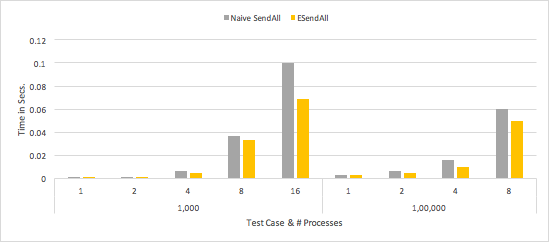

We can see that ESendAll consisently performs better. Due to low level of parallelization on my system (See Sol. 2 below), the difference is not that stark, however, it would be highly significant on real parallel machines.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 22 14:24:25 2018

@author: mundanemohit
"""

from mpi4py import MPI                      # Load MPI Library
import numpy as np

comm = MPI.COMM_WORLD                       # Initialize communicator
rank = comm.Get_rank()                        # Current worker
size = comm.Get_size()
status = MPI.Status()                       # Rank ID of sender
root = 0                                    # Setup root node

# Naive Send all
def ESendAll(rank, vec1):
        destA = 2 * rank + 1
        comm.send(vec1, dest=destA)
        print(rank, 'sent to #' , destA)
        if destA + 1 != size:
            comm.send(vec1, dest=destA+1)      
            print(rank, 'sent to #', destA + 1)
        #comm.Barrier()
        
# Initializing vectors in root node 
if (rank == root):
    TC = [10**3, 10**5, 10**7]                    # Test Cases 
    N = 1                                       # SELECT TEST CASE HERE
    vec1 = np.random.randint(1,10, size = TC[N-1])
    print('No. of workers: {}' .format(size))
    print('v1: {}...'.format(vec1[:5]))

# Sending slices to 2 consecutive workers 
# as long as destination B is less than size

wt = MPI.Wtime()

if rank != root:
    print('{} trying to recieve from {}...' .format(rank, int(np.ceil(rank/2))-1))
    vec1 = comm.recv(source= int(np.ceil(rank/2))-1)
    print('Data recieved')
if 2 * rank + 1 < size:
    print('Sending data...')
    ESendAll(rank, vec1)
print('Process {}: {} secs.' .format(rank, MPI.Wtime() - wt))

No. of workers: 1
v1: [3 1 9 3 1]...
Process 0: 0.00016689300537109375 secs.


## Exercise 2: Collective Communication (10 Points)

+ In this exercise you have to find an Image histogram. 
+ Images generally have RGB or gray scale values. 
+ Finding histogram is just calculating the frequency of occurrence of each gray scale or RGD value.
+ You have to provide parallel implementation using collective routines only.

**Note:** You have to implement frequency calculation and you should not use opencv or other build-in methods for frequency calculation.

Along with the code, please explain the following:

1. Pick an image with a high resolution i.e. resolution ≥ 2048x2048.
2. Data division strategy i.e. how you divide your data among processes.
3. How you assign tasks to different processes?
4. How you combine results from all the processes?
5. Did you implement for RGB or gray scale histogram? ( 2 points if it works with both)
6. Provide runtime analysis on varying number of processes i.e. [1, 2, 3, 4]. You have to show that your solution actually is reducing time to calculate histogram, if you add more processes. (3 points)

**Note:** If you dont know how to read an image in python, please see Annex below. (Install, use opencv and histogram tutorial)


## Solution

For this problem, we choose the most beautiful image available on the internet, that of Emma Watson. 

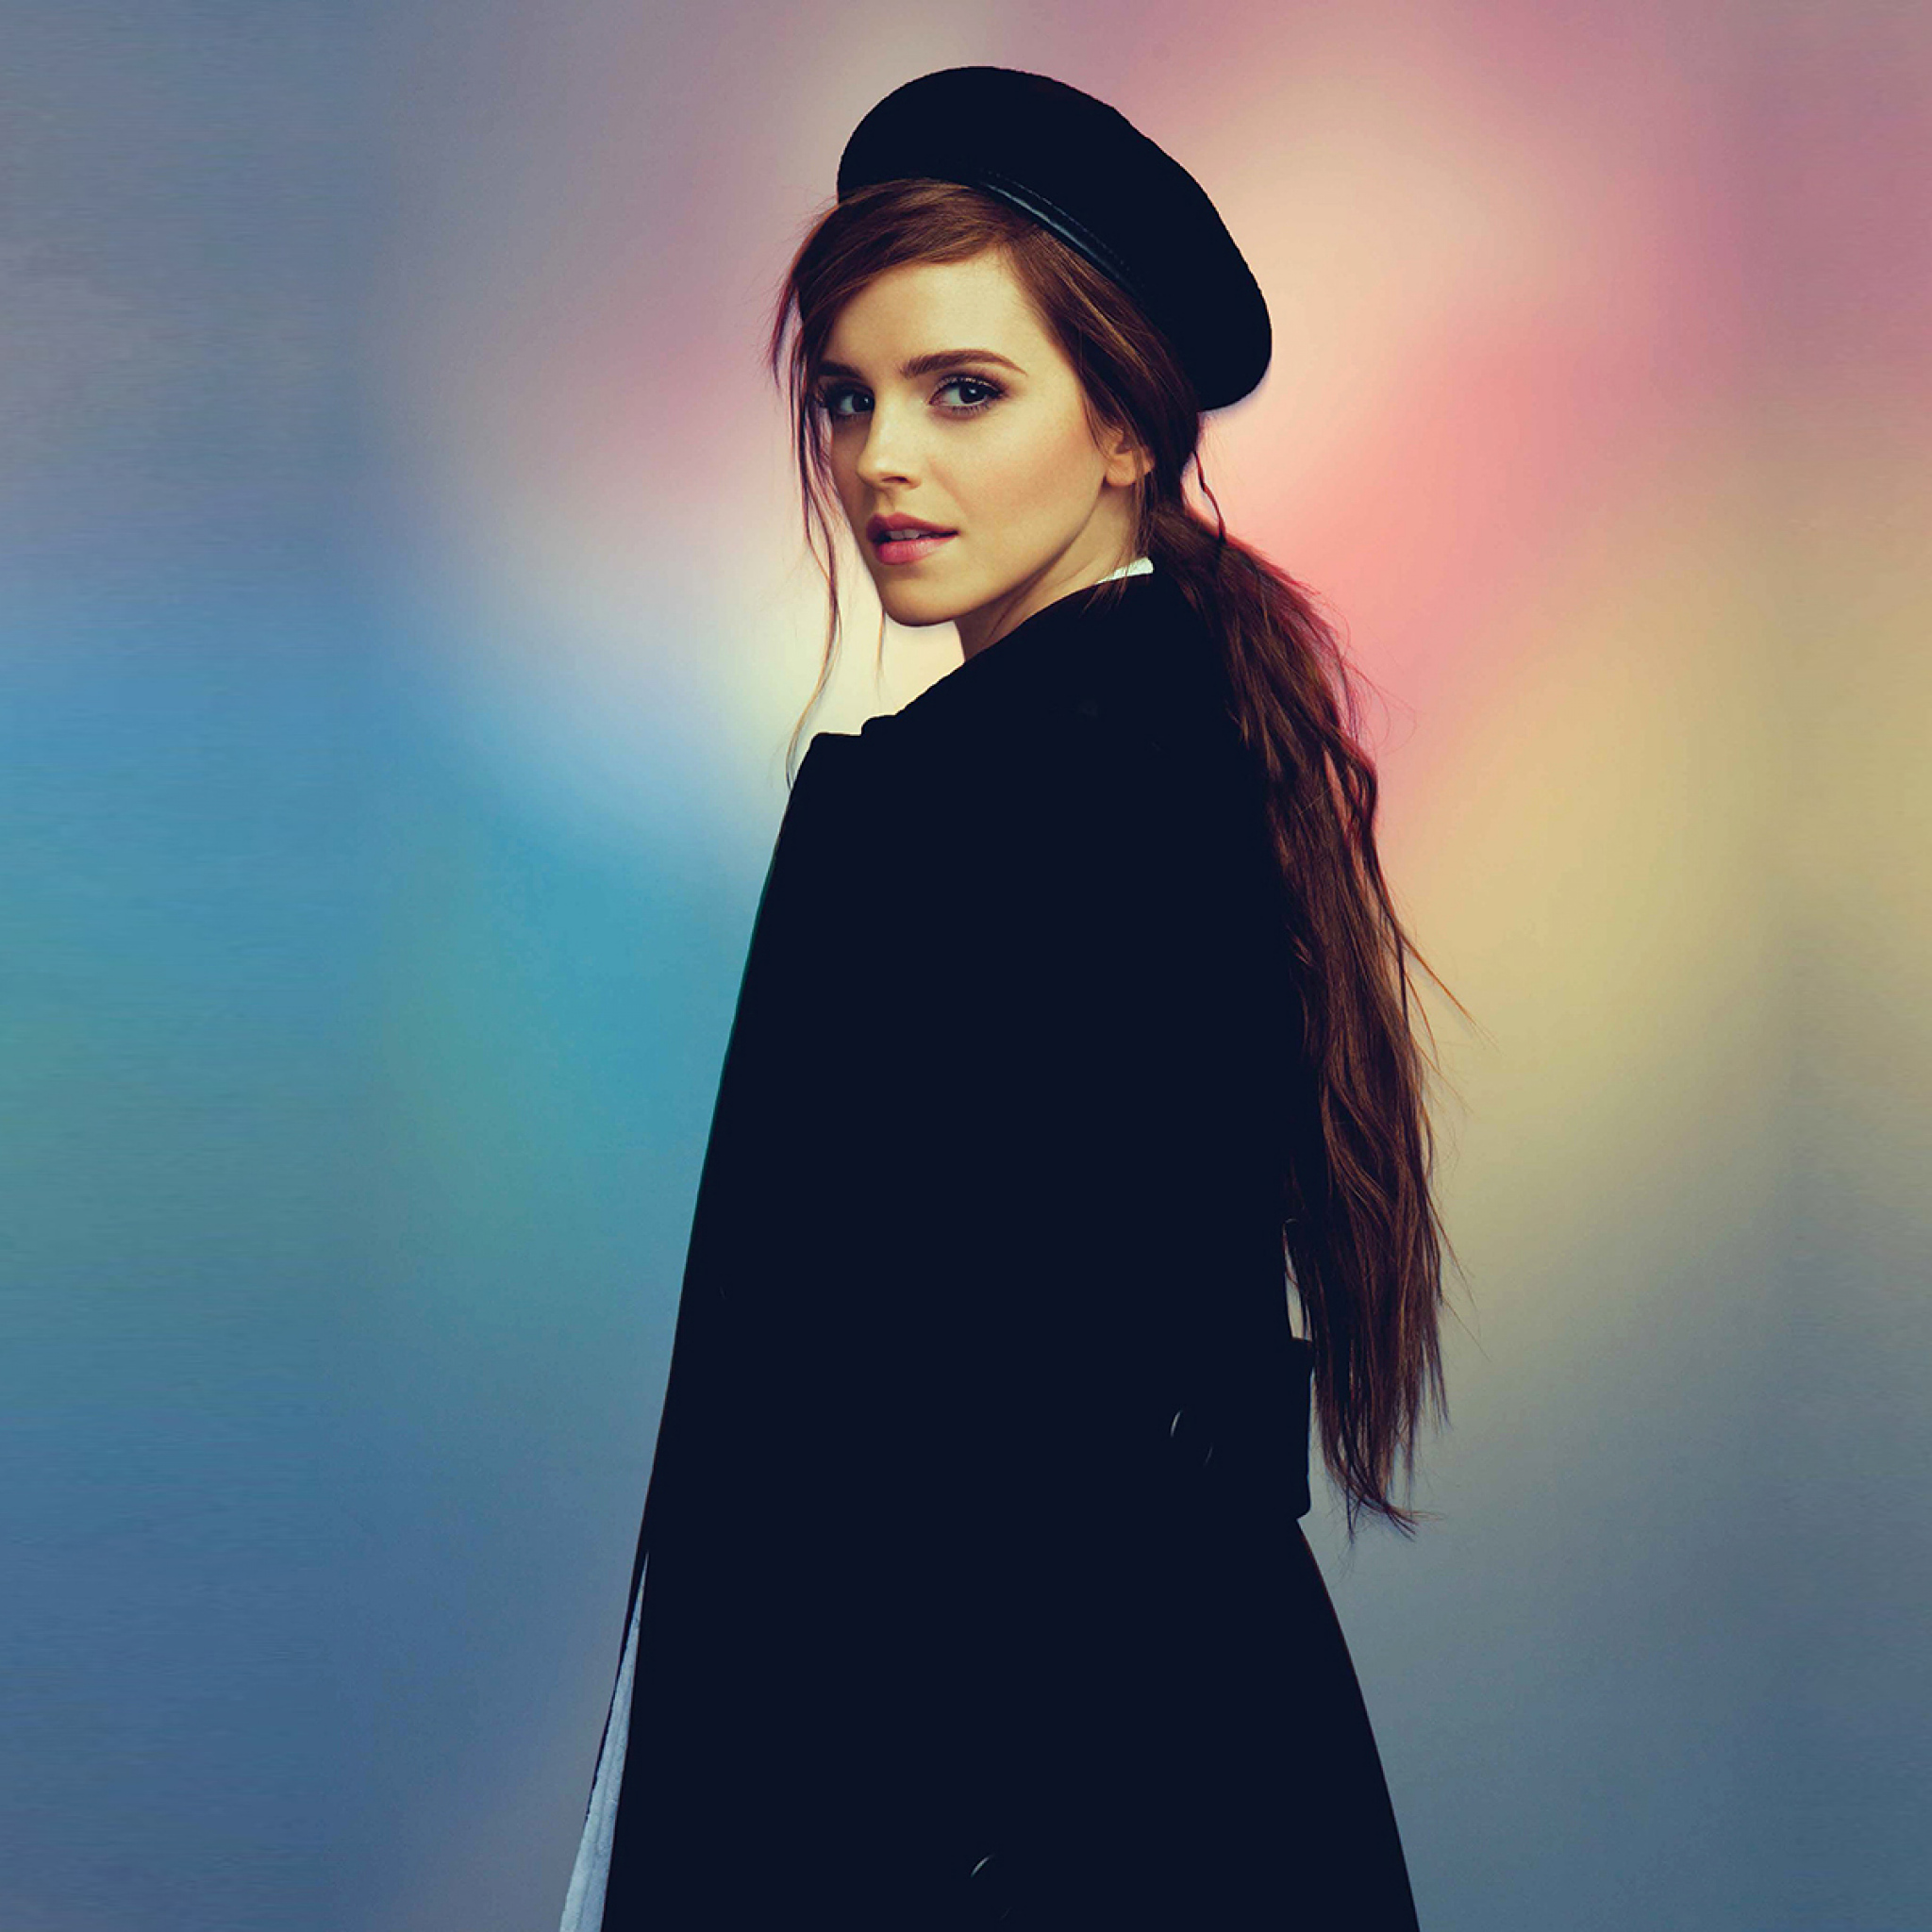

We have a $2048 * 2048 * 3$ Image matrix with RGB values ranging from 0 to 255 for each pixel.

We use the steps learnt in previous excercise 1 to scatter a matrix by dividing N rows into P slices based on number of workers:

+ Root node scatters the slices to workers


+ For each pixel, workers calculate the following 5 metrics:
    + **RGB Intensity** - Average of RGB value for each pixel (Denoted by gray line)
    + **Red Intensity** - Pixel value of red (Denoted by red line)
    + **Green Intensity** - Pixel value of green (Denoted by green line)
    + **Blue Intensity** - Pixel value of blue (Denoted by blue line)
    + **Grayscale Intensity** - Grayscale is calculated as $0.07.R + 0.72.G + 0.21.B$


+ Root gathers the results and plots them using *hist()*

Below are the results:

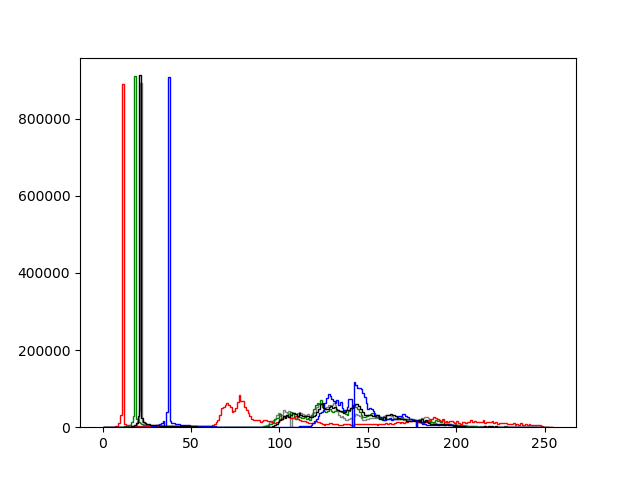

### Performance:

The results upon increase number of processors are peculiar at first. But upon further investigation the results seem quite plausible. Below are the results:

|# Processes | # Rows per Worker | Avg. Computation time per worker (Secs.) | Avg. Threads per Process| 
|------------|:-----------:|:-----------------------------:|:------------------|
|1    |2048	|101.9 Sec.|2
|2    |1024	|60.3 Sec.|2
|4	   |512	|57.08 Sec.|2
|8	   |256	|57.08 Sec.|2
|16   |128	|58.34 Sec.|2

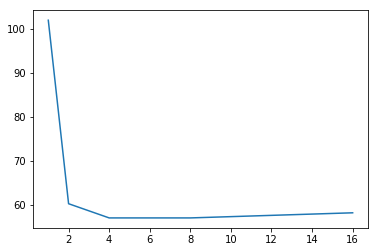

It seems that computation time is halved when we move from 1 to 2 processors, however, it isn't affected much when adding more processors. This is probably because we only have 2 threads for each process. Since we are running it on a single machine, we are able to parallelize only 2 threads at a time. (even though we have 4 cores, 2 might be reserved for critical system processes).

Moreover, upon adding more processors, the switching time between threads and processes just adds to the overall computation time without any further improvement.

My hypothesis is that on a real distributed environment, the calculation time would decrease by inverse square law.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 23 10:21:58 2018

@author: mundanemohit
"""

import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpi4py import MPI                      # Load MPI Library
from decimal import Decimal, ROUND_HALF_UP

comm = MPI.COMM_WORLD                       # Initialize communicator
rank=comm.Get_rank()                        # Current worker
status = MPI.Status()                       # Rank ID of sender
root = 0                                    # Setup root node

if rank == root: 
    size = comm.Get_size()
    print('No. of workers: {}' .format(size))
    # LOAD IMAGE 
    #img = cv2.imread('skittles.jpg')
    img = cv2.imread('emma.jpg')
    cv2.imshow('EMMA', img)   size = comm.Get_size()   # Display image

    # Send n rows to P workers
    slice = int(Decimal(img.shape[0]/size).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      
    print('Slice size: {}'.format(slice))
    sliceA = []
    
    # Create slices for scattering
    for i in range(0,size):
        if i < size - 1:
            sliceA.append([img[slice*i:slice*(i+1)]])
        else:
            sliceA.append([img[slice*i:]])
else:
    sliceA = None

wt = MPI.Wtime()

# Sending slices to workers   
sliceA = comm.scatter(sliceA, root = root)

img_A, img_R, img_G, img_B, img_GS = [], [], [], [], []
for i in range(0, sliceA[0].shape[0]):
    for j in range(0, sliceA[0].shape[1]):
        img_A.append(int(np.mean(sliceA[0][i][j])))         # Average of RGB values
        img_R.append(sliceA[0][i][j][2])                    # Red 
        img_G.append(sliceA[0][i][j][1])                    # Green
        img_B.append(sliceA[0][i][j][0])                    # Blue
        img_GS.append(sliceA[0][i][j][2]*0.07
                      +sliceA[0][i][j][1]*0.72
                      +sliceA[0][i][j][0]*0.21)             # Grayscale formula

# GatheriNG all types of data for plotting histogram
img_A = comm.gather(np.squeeze(img_A), root=root)
img_R = comm.gather(np.squeeze(img_R), root=root)
img_G = comm.gather(np.squeeze(img_G), root=root)
img_B = comm.gather(np.squeeze(img_B), root=root)
img_GS = comm.gather(np.squeeze(img_GS), root=root)

print('Process {}: {} secs.' .format(rank, MPI.Wtime() - wt))

if rank == root:
    img_A = np.concatenate(img_A)
    img_R = np.concatenate(img_R)
    img_G = np.concatenate(img_G)
    img_B = np.concatenate(img_B)
    img_GS = np.concatenate(img_GS)
    
    # Print histograms
    plt.hist(img_A,255, color = 'grey', histtype = 'step')
    plt.hist(img_G,255, color = 'green', histtype = 'step')
    plt.hist(img_R,255, color = 'red', histtype = 'step')
    plt.hist(img_B,255, color = 'blue', histtype = 'step')
    plt.hist(img_GS,255, color = 'black', histtype = 'step')
    plt.show()   

No. of workers: 1
Slice size: 2048
Process 0: 103.31057691574097 secs.


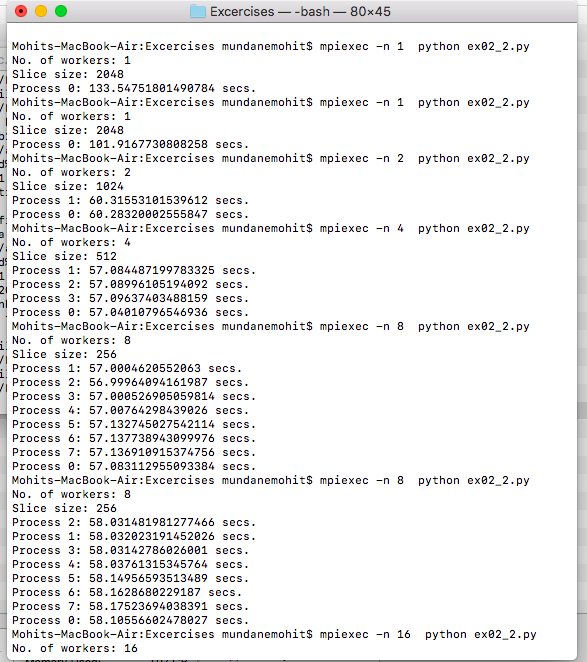